In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as tdatasets
import umap.umap_ as umap
from sklearn.datasets import fetch_mldata
import seaborn as sns

from fastai import datasets,layers
from fastai.vision import ImageList
from fastai.basic_train import Learner
from fastai.basic_data import DataBunch
from fastai.callback import Callback
from ipdb import set_trace
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
from functools import partial
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import torchvision.datasets as tdatasets
import torch.nn as nn
import numpy as np
import hdbscan
import utils

def reload():
    import importlib, utils
    importlib.reload(utils)
reload()

In [3]:
mnist_dl = utils.get_mnist_dloader()

In [4]:
enc,dec,_ = utils.get_enc_dec(device='cuda',latent_size=10)

In [5]:
rloss_func = nn.L1Loss(reduction='none')
labloss_func = nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(params = [{'params':enc.parameters()},{'params':dec.parameters()}])

In [6]:
writer = SummaryWriter()

In [21]:
def train_epoch(enc,dec,dl,check_acc,epoch_num=0):
    base = epoch_num*len(mnist_dl)
    wrong_xs = torch.zeros(1,28,28,device='cuda').float()
    wrong_ys = torch.zeros(1,device='cuda',dtype=torch.int64)
    for i,dp in enumerate(mnist_dl):
        x,y = dp
        latent = enc(x)
        rec = dec(latent)
        acc = latent[:,:,0,0].argmax(dim=-1) == y
        if check_acc:
            new_wrong_xs = x[~acc]
            new_wrong_ys = y[~acc]
            wrong_xs = torch.cat([wrong_xs,new_wrong_xs.squeeze(1)],dim=0)
            wrong_ys = torch.cat([wrong_ys,new_wrong_ys],dim=0)
        rloss = rloss_func(x,rec).mean(dim=[1,2,3])
        labloss = labloss_func(latent[:,:,0,0],y)
        ohe_latent = (torch.arange(10,device='cuda') == y[:,None]).float()[:,:,None,None]
        constr = dec(ohe_latent)
        constr_loss = rloss_func(x,constr).mean(dim=[1,2,3])
        easys = labloss < 0.001
        if easys.sum() > 60: print(easys.sum())
        loss = rloss[~easys].mean() + labloss.mean() + constr_loss[easys].mean()
        loss.backward(); opt.step(); opt.zero_grad()
        writer.add_scalar('ae_loss',rloss.mean(),base+i)
        writer.add_scalar('lab_loss',labloss.mean(),base+i)
    return wrong_xs, wrong_ys

for epoch in range(2):
    print(f'Epoch {epoch}')
    train_epoch(enc,dec,mnist_dl,check_acc=False)
    
final_wrong_xs, final_wrong_ys = train_epoch(enc,dec,mnist_dl,check_acc=True)
len(final_wrong_xs), len(final_wrong_xs)/60000

Epoch 0
Epoch 1


390

In [18]:
len(mnist_dl)*64

59968

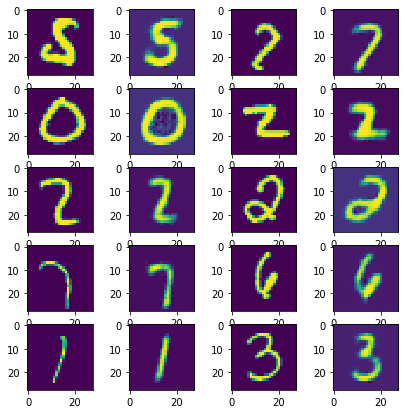

In [19]:
for x,y in mnist_dl:
    utils.check_ae_images(enc,dec,x)
    break

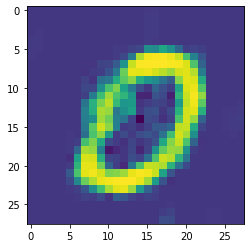

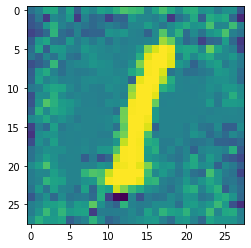

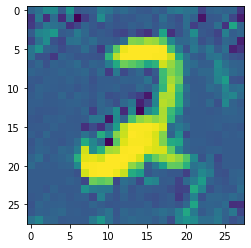

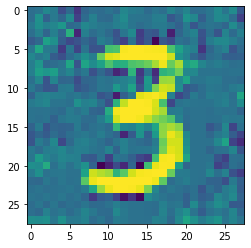

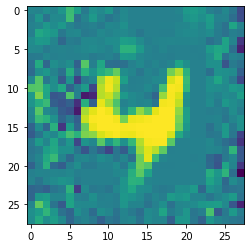

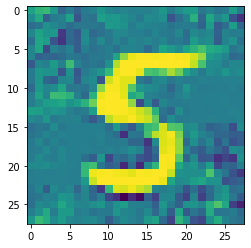

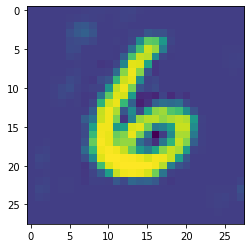

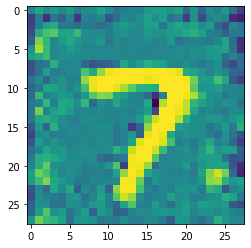

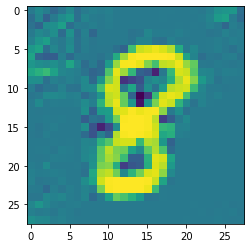

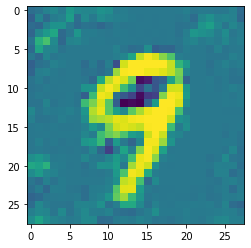

In [20]:
utils.check_ohe_latents(dec,10)